Ли-Зан-Мен Сергей

lizanmensergej@gmail.com

Задача kaggle: https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/overview

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings(action='ignore')


Поля:
* bathrooms: количество ванных
* bedrooms: количество спальн
* building_id: id здания
* created: дата создания здания (или объявления)?
* description: описание дома
* display_address: отображаемый на сайте адрес 
* features: список особенностей дома
* latitude: географическая широта
* listing_id: id объявления?
* longitude: географическая долгота
* manager_id: id менеджера работающего со зданием
* photos: список ссылок на фотографии дома
* price: цена в тысячах usd
* street_address: полный адрес
* interest_level: привлекательность дома в трех градациях: 'high', 'medium', 'low'

# Импорт и предобработка

In [2]:
#  Сразу сбрасываем индексы для удобства
df_train = pd.read_json('train.json').reset_index(drop=True)

df_train.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
0,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
1,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low
2,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium


In [3]:
# Проверка на пустые значения и типы
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49352 entries, 0 to 49351
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 5.6+ MB


Необходимые преобразования для будущей функции обработки:
* Перевести created  в объект datetime
* Удалить все id - эти поля не несут информации
* Посчитать колличество фотографий 
* `Как то преобразовать display_address и street_address`
* `Как то преобразовать decription и features`

In [4]:
# Сравниваем значения для полей с адресами
df_train[['display_address', 'street_address']]

,display_address,street_address
0,145 Borinquen Place,145 Borinquen Place
1,East 44th,230 East 44th
2,East 56th Street,405 East 56th Street
3,Metropolitan Avenue,792 Metropolitan Avenue
4,East 34th Street,340 East 34th Street
...,...,...
49347,W 171 Street,620 W 171 Street
49348,Broadway,3333 Broadway
49349,210 Brighton 15th St,210 Brighton 15th St
49350,West 21st Street,350 West 21st Street


In [5]:
# Уникальные значения для display_address
df_train.display_address.value_counts()

Broadway              438
East 34th Street      355
Second Avenue         349
Wall Street           332
West 37th Street      287
                     ... 
 W 37th St              1
570 83rd Street         1
1002 Bushwick Ave       1
Verandah Place          1
Columbus                1
Name: display_address, Length: 8826, dtype: int64

In [6]:
# Уникальные значения для street_address
df_train.street_address.value_counts()

3333 Broadway                  174
505 West 37th Street           167
200 Water Street               160
90 Washington Street           142
100 Maiden Lane                131
                              ... 
577 East 184 Street              1
11 1/2 West 26th Street          1
\t100 Jane Street, Apt. 7-D      1
524 East 11th Street             1
110 W 74 St.                     1
Name: street_address, Length: 15358, dtype: int64

`Как то преобразовать display_address и street_address`

В тренировочном df на 49351 наблюдений приходится 8826 уникальных адресов для display_address и 15358 для street_address. Можно сказать, что display_address это обобщенный адрес и его можно использовать как категориальный тип, но можно еще обобщить эти данные: иногда в display_address появляется цифра в начале, т.е. номер дома, если избавиться от этого значения мы получим набор улиц.

street_address просто дублирует информацию, поэтому его лучше удалить для избежания коллинеарности

In [7]:
# Сравниваем значения для полей с описание и особенностями
df_train.iloc[0].description

'Spacious 1 Bedroom 1 Bathroom in Williamsburg!Apartment Features:- Renovated Eat in Kitchen With Dishwasher- Renovated Bathroom- Beautiful Hardwood Floors- Lots of Sunlight- Great Closet Space- Freshly Painted- Heat and Hot Water Included- Live in Super Nearby L, J, M & G Trains !<br /><br />Contact Information:Kenneth BeakExclusive AgentC: 064-692-8838Email: kagglemanager@renthop.com, Text or Email to schedule a private viewing!<br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><p><a  website_redacted '

In [8]:
df_train.iloc[0].features

['Dining Room',
 'Pre-War',
 'Laundry in Building',
 'Dishwasher',
 'Hardwood Floors',
 'Dogs Allowed',
 'Cats Allowed']

`Как то преобразовать decription и features`

decription - описание здание, которое по содержанию может дублировать другие поля (количество ванных или особенности этого дома. Поэтому посчитаем колличество слов, большое описание может быть весомым признаком к привлекательности дома

features - лист с особенностями дома. Просто посчитать колличество это обесценивание признаков. Например, наличие лифта фактор может быть весомее фактором, чем фитнес центр в здании (жиза). Необходимо найти общее число признаков на все дома, отобрать самые встречаемые и преобразовать в One-hot формат

In [9]:
# Регуляторные выражения и nltk для обработки слов
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 

import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\OgO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Второстепенная функция для перевода списка features в список, 
# где каждая особенность стеммингизированна соединена _

def filtered_features(features_list, stemmer=PorterStemmer(),
                      stop_words=set(stopwords.words("english"))):
    # Список для преобразованных features
    cleaned_features = []
    
    for feature in features_list:
        # Для каждой особенности удаляем лишние знаки 
        feature = re.sub(r'\W+', ' ', feature)
        
        # Токенизируем - разбиваем по словам
        feature_words = nltk.word_tokenize(feature)
        
        # Список слов для одной особенности
        filtered_words = []
        for word in feature_words:
            if word not in stop_words:
                # Если слово не стоп-слово то стем. - сокращаем до корня и добавляем в список
                filtered_words.append(stemmer.stem(word))
        # Добавляем в список признаки через _     
        cleaned_features.append('_'.join(filtered_words))
    return cleaned_features

In [11]:
# Функция для подсчета слов в description
def number_words_in_description(desc):
    # Удаляем лишние знаки
    desc = re.sub(r'\W+', ' ', desc)
    # Токенизируем
    desc_list = nltk.word_tokenize(desc)
    # Удаляем остатки меток от html. Можно добавить больше условий, чтобы получать более точное количество 
    desc_list = list(filter(lambda word: word not in ('br', 'p', 'a', 'website_redacted'), desc_list))
    
    # Возвращаем кол-во слов
    return len(desc_list)

In [12]:
# Функция выполняющия вышеуказанные преобразования
def transform_dataframe(df):
    # Удалить все id и street_address
    df.drop(['building_id', 'listing_id', 'manager_id', 'street_address'], 
            axis=1, inplace=True)
    
    # Перевести created в объект datetime
    df.created = pd.to_datetime(df.created)
    
    # Посчитать колличество фотографий
    df['number_of_photos'] = df.photos.apply(lambda photos_list: len(photos_list))
    df.drop('photos', axis=1, inplace=True)
    
    # Удалить цифры в начале display_address и привести к формату lowercase_underscore 
    pattern = r'^\d+\s'
    df.display_address = df.display_address.apply(lambda address: re.sub(pattern, '', address))
    df.display_address = df.display_address.apply(lambda address: '_'.join(address.lower().split(' ')))
    
    # Считаем слова в description
    df['words_in_description'] = df.description.apply(number_words_in_description)
    df.drop('description', axis=1, inplace=True)
    
    # Приведем список обосенностей к формату lowercase_underscore 
    df.features = df.features.apply(filtered_features)
    
    return df

In [13]:
# Сравним результаты
df_train.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
0,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
1,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low
2,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium


In [14]:
%%time
# Долгая функция конечно
df_train_transform = transform_dataframe(df_train.copy())

Wall time: 42.8 s


In [15]:
# Видим, что все работает
df_train_transform.head(2)

,bathrooms,bedrooms,created,display_address,features,latitude,longitude,price,interest_level,number_of_photos,words_in_description
0,1.0,1,2016-06-16 05:55:27,borinquen_place,"[dine_room, pre_war, laundri_build, dishwash, ...",40.7108,-73.9539,2400,medium,12,60
1,1.0,2,2016-06-01 05:44:33,east_44th,"[doorman, elev, laundri_build, dishwash, hardw...",40.7513,-73.9722,3800,low,6,125


In [16]:
# Категориальные данные - features, display_address и interest_level
# Дата -created
# Все остальные количественные
df_train_transform.dtypes

bathrooms                      float64
bedrooms                         int64
created                 datetime64[ns]
display_address                 object
features                        object
latitude                       float64
longitude                      float64
price                            int64
interest_level                  object
number_of_photos                 int64
words_in_description             int64
dtype: object

# Exploratory data analysis
Во время предобработки появилось несколько гипотез:
* Уровень привлекательности отрицательно зависит от цены
* Чем выше цена, тем больше ванных и спален
* Уровень привлекательности в среднем одинаковы для каждого периода времени

In [17]:
# Настройки для графиков
sns.set(style='whitegrid',
        font_scale=1.2,
        rc={'figure.figsize': (14, 6)})

In [18]:
# Функция для подписи графика
def sets_for_plot(plot, title='', title_fontsize=22, 
                  xlabel='', xlabel_fontsize=18, 
                  ylabel='', ylabel_fontsize=18):
    
    plot.set_title(title, fontsize=title_fontsize)
    plot.set_xlabel(xlabel, fontsize=xlabel_fontsize)
    plot.set_ylabel(ylabel, fontsize=ylabel_fontsize)

#### Рассмотрим целевую переменную

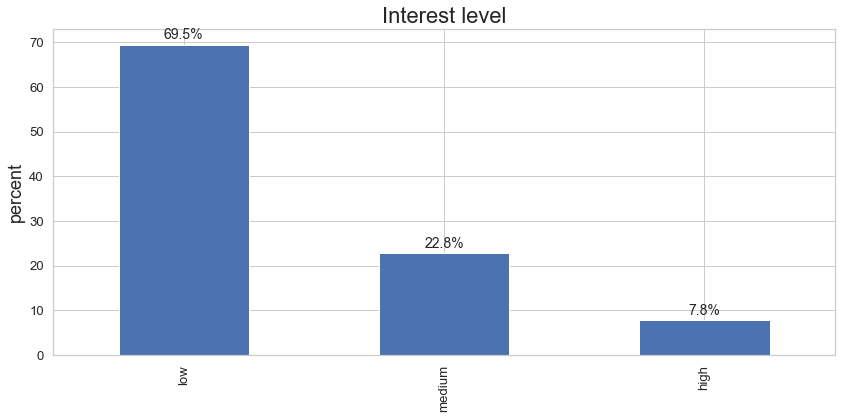

In [19]:
# нормализация целевого значения и график
bp = df_train_transform.interest_level.value_counts(normalize=True).mul(100).plot(kind='bar')

# Подписи для графика
sets_for_plot(bp, title='Interest level', ylabel='percent')

# Подписи столбцов
for p in bp.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    bp.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center', # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points', # точка смещения относительно координаты
                fontsize=14)


Как и ожидалось у нас дисбаланс классов

#### Price
Посмотрим как связана цена и уровень привелкательности

In [20]:
df_train_transform.groupby('interest_level').describe().price.sort_values('count')

,count,mean,std,min,25%,50%,75%,max
interest_level,,,,,,,,
high,3839.0,2700.293045,2080.554641,700.0,1850.0,2400.0,3163.0,111111.0
medium,11229.0,3158.767388,1243.693856,695.0,2300.0,2895.0,3650.0,15000.0
low,34284.0,4176.599142,26449.321549,43.0,2625.0,3300.0,4400.0,4490000.0


<AxesSubplot:xlabel='interest_level', ylabel='price'>

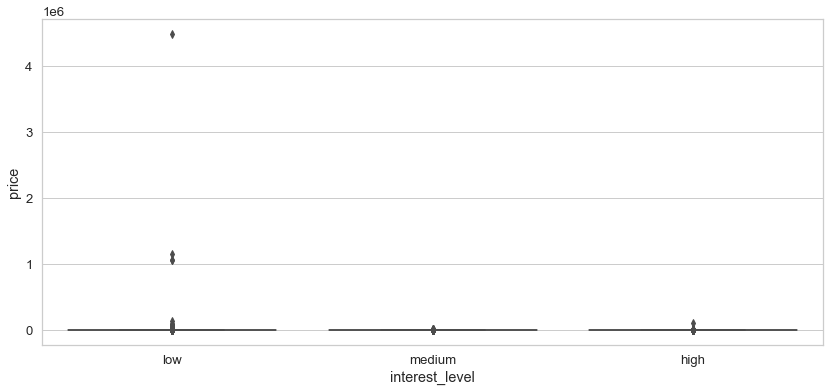

In [21]:
# Boxplot price
sns.boxplot(data=df_train_transform, y='price', x='interest_level', order=['low', 'medium', 'high'])

Видно, что для каждого уровня среднее значение и медиана соотносимы, но все портят выбросы. Они могут негативно повлиять и на нашу модель.

In [22]:
# Определим квантиль
for q in np.arange(0.9, 1, 0.01):
    q = round(q, 2)
    value = round(df_train_transform.price.quantile(q=q))
    print(f'Пороговое значения для {q=} : {value}')

Пороговое значения для q=0.9 : 5652
Пороговое значения для q=0.91 : 5890
Пороговое значения для q=0.92 : 6000
Пороговое значения для q=0.93 : 6200
Пороговое значения для q=0.94 : 6495
Пороговое значения для q=0.95 : 6895
Пороговое значения для q=0.96 : 7390
Пороговое значения для q=0.97 : 8000
Пороговое значения для q=0.98 : 9995
Пороговое значения для q=0.99 : 13000


Заметен резкий скачок для 99% перцентиля, попробуем избавиться от выбросов по нему

In [23]:
# Копируем df
df = df_train_transform.copy()

In [24]:
# Округляем значения до 99 процентиля
percentile_99 = round(df_train_transform.price.quantile(q=0.99))
df.price.loc[df.price>percentile_99] = percentile_99

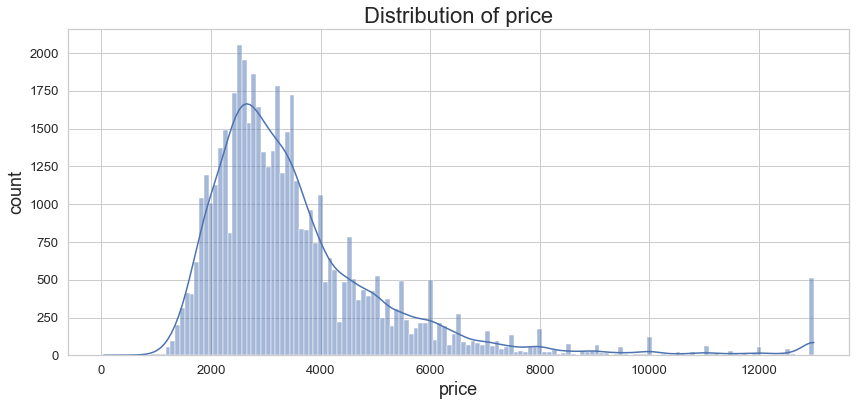

In [25]:
hp = sns.histplot(data=df, x='price', kde=True)
sets_for_plot(hp, title='Distribution of price', xlabel='price', ylabel='count')

Распределение скошено вправо, выбросы все еще есть

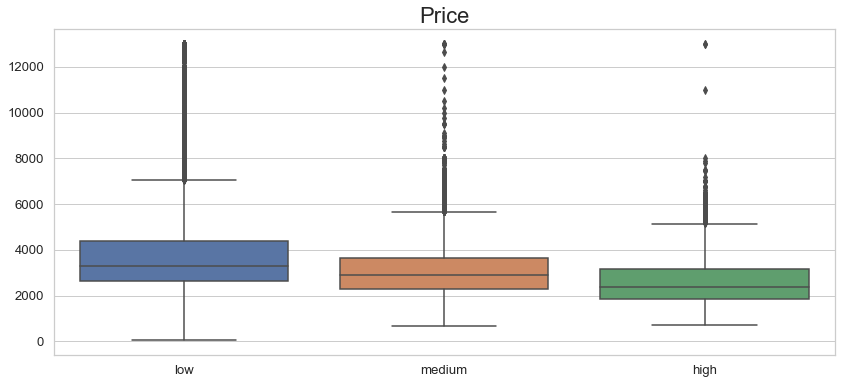

In [26]:
bp = sns.boxplot(data=df, y='price', x='interest_level', order=['low', 'medium', 'high'])
sets_for_plot(bp, title='Price')

Замечена корреляция, что чем ниже цена, тем выше уровень привлекательности дома

Гипотеза подтверждена

#### Связь цены и количества комнат

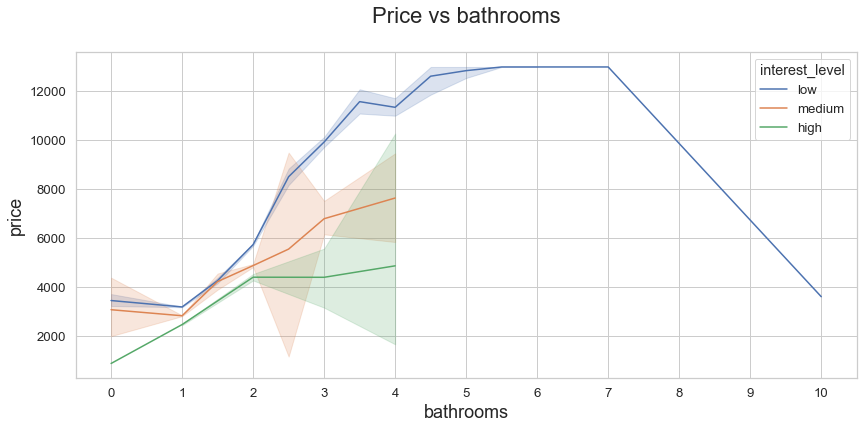

In [27]:
lp = sns.lineplot(data=df, y='price', x='bathrooms', 
                  hue='interest_level', hue_order=['low', 'medium', 'high'])

lp.set_xticks(range(11))
sets_for_plot(lp, title='Price vs bathrooms\n', xlabel='bathrooms', ylabel='price')

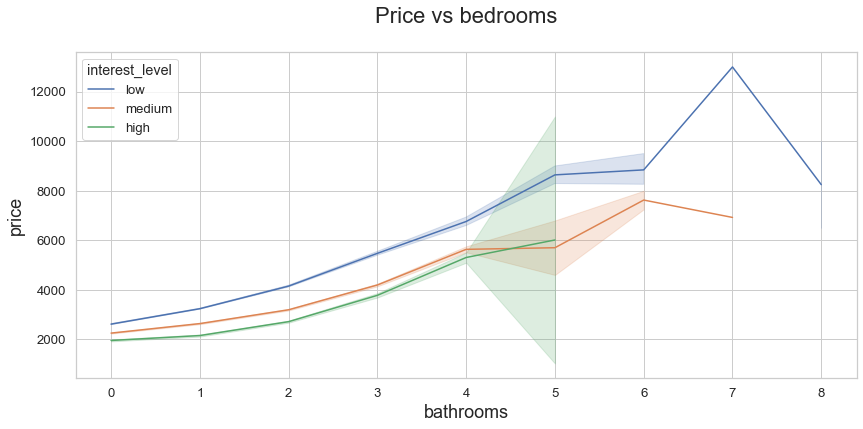

In [28]:
lp = sns.lineplot(data=df, y='price', x='bedrooms', 
                  hue='interest_level', hue_order=['low', 'medium', 'high'])
sets_for_plot(lp, title='Price vs bedrooms\n', xlabel='bathrooms', ylabel='price')

Заметна тенденция, что чем больше комнат, тем выше цена и соответственно ниже уровень привлекательности

Это говорит о корреляциимежду этими признаками, возможно в дальнейшем они будут оказывать негативное воздействие на модель

Также заметно наблюдение с огромным количеством ванных комнат и невысокой ценой. Это можно оценить как выброс, в дальнейшем возможно придется удалить

#### Привлекательность по времени

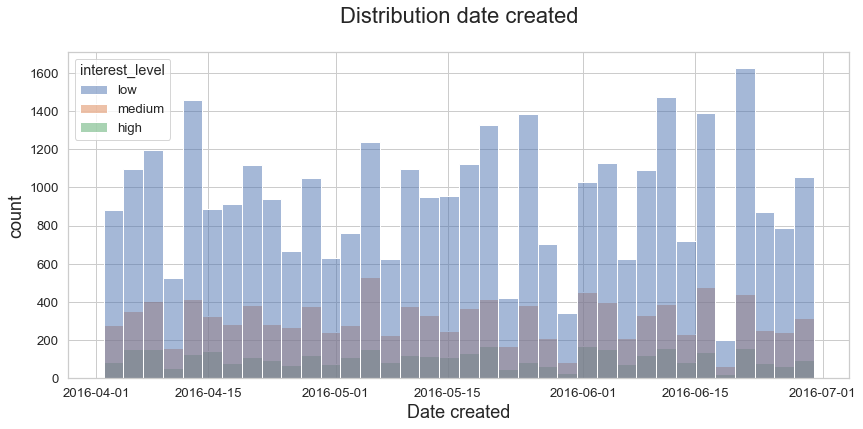

In [29]:
lp = sns.histplot(data=df, x='created',
                  hue='interest_level', hue_order=['low', 'medium', 'high'])
sets_for_plot(lp, title='Distribution date created\n', xlabel='Date created', ylabel='count')

Из даты можно извлечь в качестве переменных год, месяц, день и час создания.

Но мне кажется, что использовать год будет бессмысленно, т.к. вся обучающая выборка находится в пределах одного года, поэтому другое значение года, можнт сильно влиять на результаты (желательно конечно в обучающую добавить данные других лет, но пока просто не будет учитывать год)

Месяц также вызывает вопросы, т.к. в данных всего три месяца используется, но его оставим

In [30]:
# Добавим поля: час, день и месяц создания
df = df.assign(hour_created = df.created.dt.hour,
               day_created = df.created.dt.day,
               month_created = df.created.dt.month)
df.drop('created', axis=1, inplace=True)

In [31]:
df.head(2)

,bathrooms,bedrooms,display_address,features,latitude,longitude,price,interest_level,number_of_photos,words_in_description,hour_created,day_created,month_created
0,1.0,1,borinquen_place,"[dine_room, pre_war, laundri_build, dishwash, ...",40.7108,-73.9539,2400,medium,12,60,5,16,6
1,1.0,2,east_44th,"[doorman, elev, laundri_build, dishwash, hardw...",40.7513,-73.9722,3800,low,6,125,5,1,6


In [32]:
# Функция выводи график по периоду 
def plot_by_period(df, period):
    lp = sns.histplot(data=df, x=f'{period}_created', multiple="dodge", shrink=.8, kde=True,
                      hue='interest_level', hue_order=['low', 'medium', 'high'])
    sets_for_plot(lp, title=f'Distribution {period} created\n', xlabel=f'{period} created', ylabel='count')

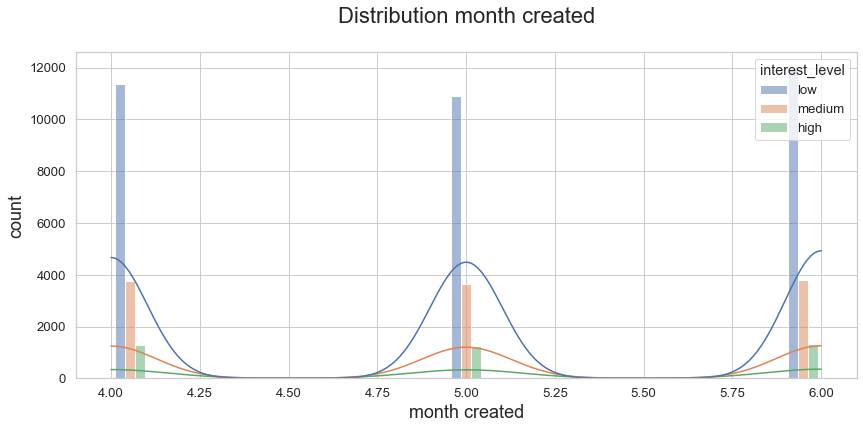

In [33]:
# Распределение по месяцам
plot_by_period(df, 'month')

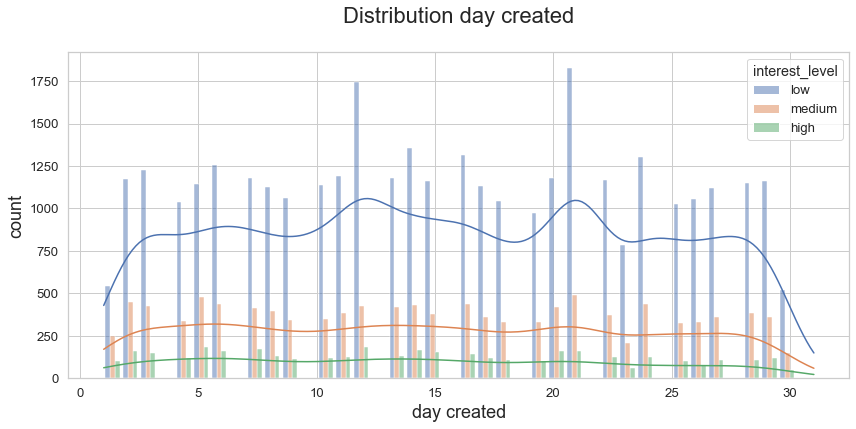

In [34]:
# Распределение по дням
plot_by_period(df, 'day')

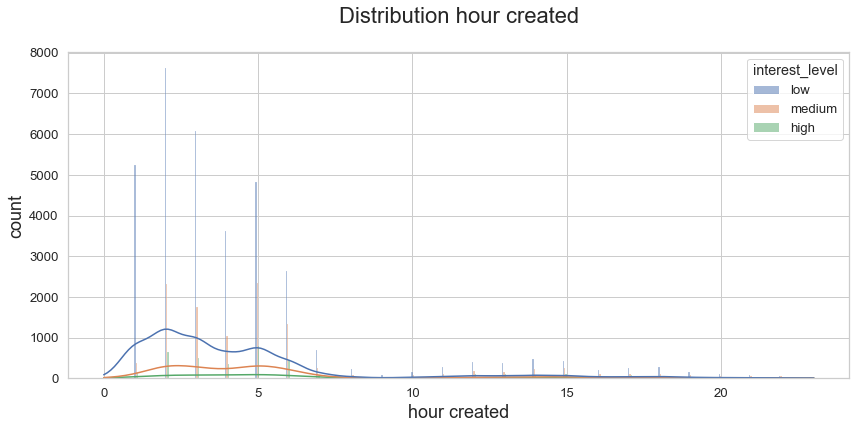

In [35]:
# Распределение по часам
plot_by_period(df, 'hour')

Нет сильной разницы в колличестве наблюдений для каждого уровня для дня и месяца.

Для часа заметно что больше наблюдений находится в промежутке от 1 до 7 часов

#### Корреляционная матрица

In [36]:
df.head(2)

,bathrooms,bedrooms,display_address,features,latitude,longitude,price,interest_level,number_of_photos,words_in_description,hour_created,day_created,month_created
0,1.0,1,borinquen_place,"[dine_room, pre_war, laundri_build, dishwash, ...",40.7108,-73.9539,2400,medium,12,60,5,16,6
1,1.0,2,east_44th,"[doorman, elev, laundri_build, dishwash, hardw...",40.7513,-73.9722,3800,low,6,125,5,1,6


In [37]:
# Отберем все количественные переменные
num_cols = [col for col, col_type in df.dtypes.iteritems() if col_type != 'object' ]
num_cols

['bathrooms',
 'bedrooms',
 'latitude',
 'longitude',
 'price',
 'number_of_photos',
 'words_in_description',
 'hour_created',
 'day_created',
 'month_created']

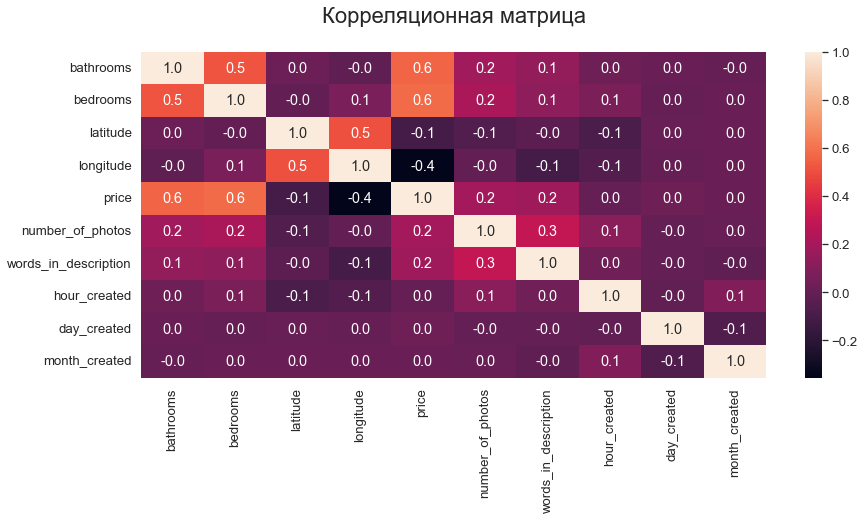

In [38]:
# Корреляционная матрица по спирмену, т.к. есть выбросы и ненормальное распределение
hp = sns.heatmap(df[num_cols].corr(method='spearman'), annot=True, fmt='.1f')
sets_for_plot(hp, title='Корреляционная матрица\n')

Гипотезы подтверждаются на корреляционной матрице. Связь между ценой и количествами комнат = заметная. Также показатели ванных и спален коррелируют заметно. Но связь не слишком высокая, убирать данные не будем.

# Feature engineering
Посмотрим на распределение всех количественных переменных

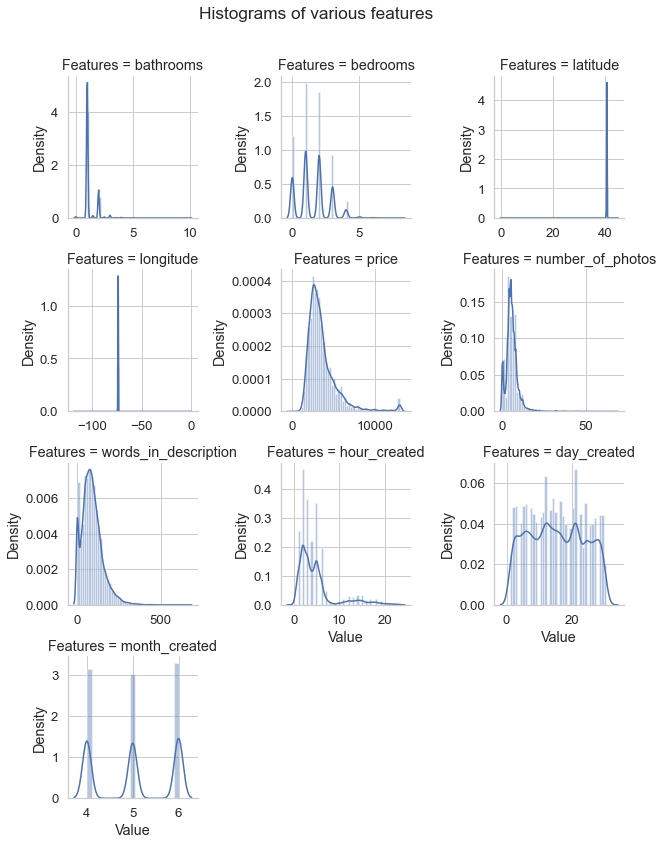

In [39]:
numeric_features = df[num_cols]

numeric_features = numeric_features.stack().reset_index().rename(
    columns={"level_1": "Features", 0: "Value"})
ax = sns.FacetGrid(data=numeric_features, col="Features",
                  col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, "Value")
plt.subplots_adjust(top=0.9)
plt.suptitle("Histograms of various features");

Скос вправо наблюдается для цены, количества фотографий, а также для количества слов в описании. Прологарифмируем эти показатели в дальнейшем. Также слишком непонятные распределения у показателей latitude и longitude, скорее всего это из-за выбросов.

#### latitude и longitude

In [40]:
# Статистики показателей
df[['latitude', 'longitude']].describe()

,latitude,longitude
count,49352.000000,49352.000000
mean,40.741545,-73.955716
std,0.638535,1.177912
min,0.000000,-118.271000
25%,40.728300,-73.991700
50%,40.751800,-73.977900
75%,40.774300,-73.954800
max,44.883500,0.000000


Квартили очень слабо различаются между собой, но минимальные и максимальные значения аномальны

In [41]:
for q in [0.0005, 0.9995]:
    print(f'При {q=} значение latitude =', df.latitude.quantile(q=q))
    print(f'При {q=} значение longitude =', df.longitude.quantile(q=q))

При q=0.0005 значение latitude = 40.5757
При q=0.0005 значение longitude = -74.10292375
При q=0.9995 значение latitude = 40.99550060000005
При q=0.9995 значение longitude = -73.38111609999936


Эти значения не попадают в 99,9% значений. Имеет смысл их округлить

In [42]:
# Округлим значения
percentile_latitude = df.latitude.quantile(q=0.0005)
df.latitude.loc[df.latitude<percentile_latitude] = percentile_latitude

percentile_latitude = df.latitude.quantile(q=0.9995)
df.latitude.loc[df.latitude>percentile_latitude] = percentile_latitude

percentile_longitude = df.longitude.quantile(q=0.0005)
df.longitude.loc[df.longitude<percentile_longitude] = percentile_longitude

percentile_longitude = df.longitude.quantile(q=0.995)
df.longitude.loc[df.longitude>percentile_longitude] = percentile_longitude

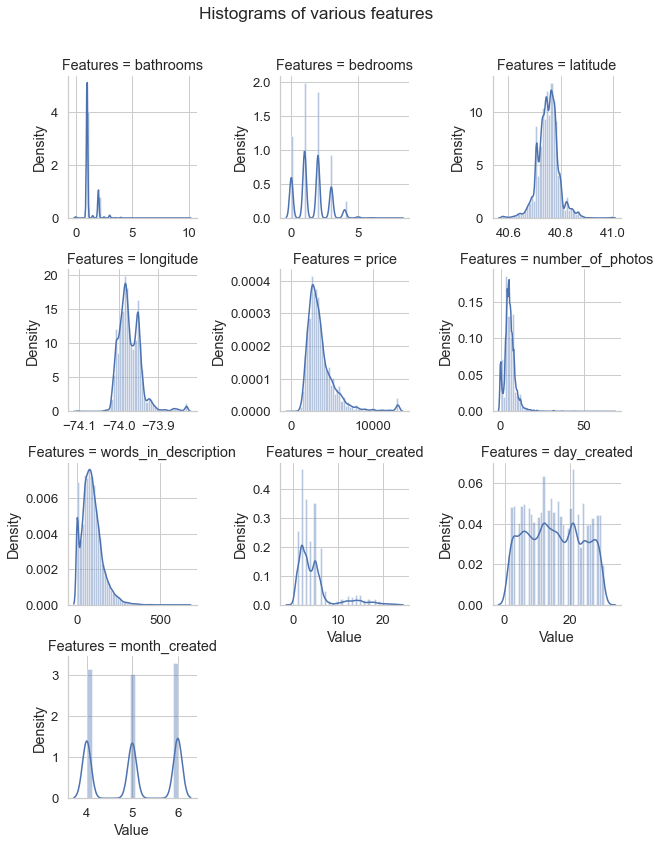

In [43]:
# Снова рассмотрим распределения
numeric_features = df[num_cols]

numeric_features = numeric_features.stack().reset_index().rename(
    columns={"level_1": "Features", 0: "Value"})
ax = sns.FacetGrid(data=numeric_features, col="Features",
                  col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, "Value")
plt.subplots_adjust(top=0.9)
plt.suptitle("Histograms of various features");

Распределения latitude и longitude заметно улучшились. У них нет скоса и в целом распределения напоминают нормальные

In [44]:
# Прологарифмируем нужные показатели
for i in ['price','number_of_photos', 'words_in_description']:
    df[i] = np.log(df[i]+1)

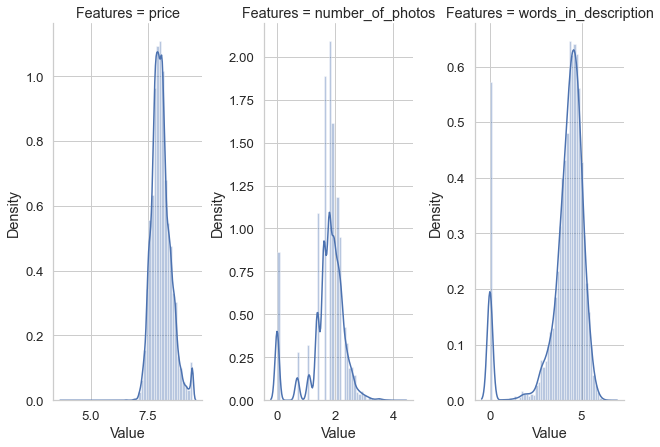

In [45]:
numeric_features = df[['price','number_of_photos', 'words_in_description']]

numeric_features = numeric_features.stack().reset_index().rename(
    columns={"level_1": "Features", 0: "Value"})
ax = sns.FacetGrid(data=numeric_features, col="Features",
                  col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, "Value")
plt.subplots_adjust(top=2)

Распределения стали уже, и меньше скошены 

#### Разбираемся с features

Сейчас у нас хранятся списки с форматированными особенностями. Необходимо привести их к виду One-hot.

In [46]:
# Получаем всевозможные особенности
stemmed_features= [item for sublist in df.features for item in sublist]

In [47]:
# Сортированный Series особенностей
unique_features = pd.Series(stemmed_features).value_counts()
unique_features.iloc[200]

6

In [48]:
# Отберем 200 особенностей и каждому наблюдению добавим столбец встречалось оно или нет
for feature in unique_features.iloc[:200].index:
    df[feature] = [1 if feature in  features_list else 0 for features_list in df.features]

In [49]:
# Удалим ненужную колонку
df.drop('features', axis=1, inplace=True)
df.head(2)

,bathrooms,bedrooms,display_address,latitude,longitude,price,interest_level,number_of_photos,words_in_description,hour_created,...,wifi,close_subway,park_avail,granit_counter_top,garbag_dispos,queen_size_bedroom,privat_roof_deck,citi_view,ton_of_natur_light,actual_photo
0,1.0,1,borinquen_place,40.7108,-73.9539,7.783641,medium,2.564949,4.110874,5,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2,east_44th,40.7513,-73.9722,8.243019,low,1.945910,4.836282,5,...,0,0,0,0,0,0,0,0,0,0


#### display_address

In [50]:
# Отберем 500 популярных адресов
popular_addresses = df.display_address.value_counts().iloc[:500].index

In [51]:
# Преобразуем в категориальную переменную
for address in popular_addresses:
    df[address] = 1 if address in df.display_address else 0

In [52]:
df.drop('display_address', axis=1, inplace=True)
df.head(2)

,bathrooms,bedrooms,latitude,longitude,price,interest_level,number_of_photos,words_in_description,hour_created,day_created,...,queens_blvd,clifton_place,carmine_street,duane_street,e_25_st.,e_57_st.,e_89th_st.,w_48_street,w_22_street,w_47th_st.
0,1.0,1,40.7108,-73.9539,7.783641,medium,2.564949,4.110874,5,16,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2,40.7513,-73.9722,8.243019,low,1.945910,4.836282,5,1,...,0,0,0,0,0,0,0,0,0,0


Это можно было сделать с помощью get_dummies, но получается слишком много независимых переменных, к тому же большинство появляется всего 1 раз, значит вряд ли они несут важную информацию для модели

In [53]:
# Категории interest_level перевести в цифры
interest_level = {'high':0, 'medium':1,'low':2}
df.interest_level = df.interest_level.apply(lambda level: interest_level[level])

In [54]:
df.head(2)

,bathrooms,bedrooms,latitude,longitude,price,interest_level,number_of_photos,words_in_description,hour_created,day_created,...,queens_blvd,clifton_place,carmine_street,duane_street,e_25_st.,e_57_st.,e_89th_st.,w_48_street,w_22_street,w_47th_st.
0,1.0,1,40.7108,-73.9539,7.783641,1,2.564949,4.110874,5,16,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2,40.7513,-73.9722,8.243019,2,1.945910,4.836282,5,1,...,0,0,0,0,0,0,0,0,0,0


In [55]:
# Датафрейм для хранения результатов
log_loss_df = pd.DataFrame(columns=['model', 'log-loss'])

# Baseline 

Для мультиклассовой классификации используем модели:
* Random Forest
* XGBoost
* Метод k-ближайших соседей
* Наивный Байес:)

In [193]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [194]:
# Зависимые и независимые переменные
X = df.drop('interest_level', axis=1)
y = df['interest_level']

In [195]:
# Разделим выборку
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, 
                                                   stratify=y, shuffle=True, random_state=42)

In [196]:
# Стандартизация данных для более точного обучения модели
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_val)

In [197]:
%%time
# Построим рандом форест с 100 деревьев
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5).fit(X_train, y_train)

Wall time: 1.86 s


In [198]:
# Оценка log-loss
y_score = rf_clf.predict_proba(X_val)
print("Log-loss =", log_loss(y_val, y_score))

Log-loss = 0.7794819863178456


Крайне переобученная модель дает неплохой результат:)

# Random Forest

Первое обучение

In [199]:
# Первые параметры для модели
param_grid = dict(n_estimators=[100],
                  max_depth=[5, 10],
                  min_samples_split=[2, 10, 50, 100],
                  min_samples_leaf=[2, 40]
                  )

In [200]:
model = RandomForestClassifier()
rf_clf_tuning = GridSearchCV(model, param_grid, cv=5)

In [201]:
%%time
rf_clf_tuning.fit(X_train, y_train)

Wall time: 5min 25s


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10], 'min_samples_leaf': [2, 40],
                         'min_samples_split': [2, 10, 50, 100],
                         'n_estimators': [100]})

In [202]:
# Лучшие параметры
rf_clf_tuning.best_params_

{'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 50,
 'n_estimators': 100}

Лучшие параметры:

{'max_depth': 10,

 'min_samples_leaf': 2,
 
 'min_samples_split': 50,
 
 'n_estimators': 100}

In [203]:
# Оценка log-loss
y_score = rf_clf_tuning.predict_proba(X_val)
print("Log-loss =", log_loss(y_val, y_score))

Log-loss = 0.774444895242144


Второе обучение

In [226]:
# Изменим количество деревьев
param_grid = dict(n_estimators=[50, 100, 250, 500, 1000],
                  max_depth=[10],
                  min_samples_split=[50],
                  min_samples_leaf=[2]
                  )

In [227]:
model = RandomForestClassifier()
rf_clf_tuning_2 = GridSearchCV(model, param_grid, cv=5)

In [228]:
%%time
rf_clf_tuning_2.fit(X_train, y_train)

Wall time: 8min 49s


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10], 'min_samples_leaf': [2],
                         'min_samples_split': [50],
                         'n_estimators': [50, 100, 250, 500, 1000]})

In [229]:
# Лучшие параметры
rf_clf_tuning_2.best_params_

{'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 50,
 'n_estimators': 250}

In [230]:
# Оценка log-loss
y_score = rf_clf_tuning_2.predict_proba(X_val)
print("Log-loss =", log_loss(y_val, y_score))

Log-loss = 0.7746024797998743


Сильной разницы в результатах нет

# XGBoost

In [204]:
# Первые параметры для модели
param_grid = dict(learning_rate=0.2, 
                  n_estimators=[100],
                  max_depth=[5, 10]
                  )

In [205]:
model = XGBClassifier(eval_metric='mlogloss', n_jobs=-1)
xgb_clf = GridSearchCV(model, parameters, cv=5)

In [206]:
%%time
xgb_clf.fit(X_train, y_train)

Wall time: 1h 1min 18s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
           

In [218]:
# Лучшие параметры
xgb_clf.best_params_

{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}

In [208]:
# Оценка log-loss
y_score = xgb_clf.predict_proba(X_val)
print("Log-loss =", log_loss(y_val, y_score))

Log-loss = 1.7715837310971425


Как-то плохо:( а я долго ждал
Где-то ошибся в параметрах, возможно

# KNeighborsClassifier 

In [231]:
# Параметры для модели
param_grid = dict(n_neighbors=range(0,101,5), weights=['uniform', 'distance'])


In [232]:
model = KNeighborsClassifier()
kn_clf = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

In [233]:
%%time
kn_clf.fit(X_train, y_train)

Wall time: 18min 25s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(0, 101, 5),
                         'weights': ['uniform', 'distance']})

In [234]:
# Лучшие параметры
kn_clf.best_params_

{'n_neighbors': 55, 'weights': 'distance'}

In [235]:
# Оценка log-loss
y_score = kn_clf.predict_proba(X_val)
print("Log-loss =", log_loss(y_val, y_score))

Log-loss = 0.8025361729030954


# Naive Baye


In [236]:
GNB_clf = GaussianNB()

In [237]:
%%time
GNB_clf.fit(X_train, y_train)

Wall time: 503 ms


GaussianNB()

In [238]:
# Оценка log-loss
y_score = GNB_clf.predict_proba(X_val)
print("Log-loss =", log_loss(y_val, y_score))

Log-loss = 10.539673620265743


Мне просто нравится наивный Байес) 

# Заключение

Получим тестовую выборку

In [239]:
df_test = pd.read_json('test.json').reset_index(drop=True)

# Сохраним сразу listing_id для будущей записи результатов
submission = pd.DataFrame()
submission["listing_id"] = df_test["listing_id"]
df_test.head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street
1,1.0,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,d0b5648017832b2427eeb9956d966a14,[https://photos.renthop.com/2/7210040_d824cc71...,2850,176 Thompson Street


In [240]:
# Функция обработки
df_test = transform_dataframe(df_test)
df_test.head(2)

,bathrooms,bedrooms,created,display_address,features,latitude,longitude,price,number_of_photos,words_in_description
0,1.0,1,2016-06-11 05:29:41,suffolk_street,"[elev, laundri_build, laundri_unit, dishwash, ...",40.7185,-73.9865,2950,8,86
1,1.0,2,2016-06-24 06:36:34,thompson_street,"[pre_war, dog_allow, cat_allow]",40.7278,-74.0000,2850,3,36


In [241]:
# Добавим поля: час, день и месяц создания
df_test = df_test.assign(hour_created = df_test.created.dt.hour,
                       day_created = df_test.created.dt.day,
                       month_created = df_test.created.dt.month)
df_test.drop('created', axis=1, inplace=True)

In [242]:
# Добавим 200 особенностей к каждому наблюдению
for feature in unique_features.iloc[:200].index:
    df_test[feature] = [1 if feature in  features_list else 0 for features_list in df_test.features]
df_test.drop('features', axis=1, inplace=True)

In [243]:
# Преобразуем в категориальную переменную display_address
for address in popular_addresses:
    df_test[address] = 1 if address in df_test.display_address else 0
df_test.drop('display_address', axis=1, inplace=True)

In [244]:
df_test.head(2)

,bathrooms,bedrooms,latitude,longitude,price,number_of_photos,words_in_description,hour_created,day_created,month_created,...,queens_blvd,clifton_place,carmine_street,duane_street,e_25_st.,e_57_st.,e_89th_st.,w_48_street,w_22_street,w_47th_st.
0,1.0,1,40.7185,-73.9865,2950,8,86,5,11,6,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2,40.7278,-74.0000,2850,3,36,6,24,6,...,0,0,0,0,0,0,0,0,0,0


# Запись результата

Выбор лучшей модели

In [254]:
def res_models(models_list):
    for model in models_list:
        y_score = model.predict_proba(X_val)
        print(f"Log-loss for {model} =", log_loss(y_val, y_score))

In [255]:
res_models([rf_clf_tuning, xgb_clf, 
           kn_clf, GNB_clf])

Log-loss for GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10], 'min_samples_leaf': [2, 40],
                         'min_samples_split': [2, 10, 50, 100],
                         'n_estimators': [100]}) = 0.774444895242144
Log-loss for GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
             

Лучшие показатели у Random Forest

In [257]:
sub_result = rf_clf_tuning.predict_proba(df_test)

In [258]:
for label in ["high", "medium", "low"]:
    submission[label] = sub_result[:, interest_level[label]]
submission.to_csv("submission.csv", index=False)